#### Check if the data requires some preprocessing. At the very least, you should have the data scaled for k-means and PCA. Take into account that you can always unscale the data for better interpretation of the results.


In [37]:
import pandas as pd

df = pd.read_csv("customer_data_large.csv")

print(df.head())  
print(df.info())
print(df.isnull().sum())
print(df.describe()) 

   Education  Kidhome  Recency  MntWines  MntFruits  MntSweetProducts  \
0          3        0       58       635         88                88   
1          3        1       38        11          1                 1   
2          3        0       26       426         49                21   
3          3        1       26        11          4                 3   
4          5        1       94       173         43                27   

   MntGoldProds  NumWebPurchases  NumStorePurchases  NumWebVisitsMonth  Age  \
0            88                8                  4                  7   65   
1             6                1                  2                  5   63   
2            42                8                 10                  4   57   
3             5                7                  4                  6   38   
4            15                5                  6                  5   41   

   Years_customer  Num_AcceptedCmp  MntFishMeatProdcts  
0              10            

It is crucial to scale the data before implementing k-means, due to the method being distance based. If values are on different scales, their influence might differ. 

Scaling can be done with multiple libraries. However, in the scope of this project, sklearn's MinMaxScaler will be used. 

Comparing the outputs from df_scaled.head() to the previous df.head(), we now see that all the data is between 0 and 1. 

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

nimaScaler = MinMaxScaler()
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_nima_scaled = pd.DataFrame(nimaScaler.fit_transform(df), columns=df.columns)

print(df_nima_scaled.head())

   Education  Kidhome   Recency  MntWines  MntFruits  MntSweetProducts  \
0        0.5      0.0  0.585859  0.425318   0.442211          0.334601   
1        0.5      0.5  0.383838  0.007368   0.005025          0.003802   
2        0.5      0.0  0.262626  0.285332   0.246231          0.079848   
3        0.5      0.5  0.262626  0.007368   0.020101          0.011407   
4        1.0      0.5  0.949495  0.115874   0.216080          0.102662   

   MntGoldProds  NumWebPurchases  NumStorePurchases  NumWebVisitsMonth  \
0      0.243094          0.25000           0.307692               0.35   
1      0.016575          0.03125           0.153846               0.25   
2      0.116022          0.25000           0.769231               0.20   
3      0.013812          0.21875           0.307692               0.30   
4      0.041436          0.15625           0.461538               0.25   

        Age  Years_customer  Num_AcceptedCmp  MntFishMeatProdcts  
0  0.709091             1.0              0.

In [39]:
from sklearn.cluster import KMeans

km_model = KMeans(n_clusters=6,random_state=11)
km_model.fit(df_nima_scaled)

KMeans(n_clusters=6, random_state=11)

In [40]:
centers = pd.DataFrame(km_model.cluster_centers_,columns=df_nima_scaled.columns)

centers

,Education,Kidhome,Recency,MntWines,MntFruits,MntSweetProducts,MntGoldProds,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Num_AcceptedCmp,MntFishMeatProdcts
0,0.516064,0.390562,0.348221,0.053827,0.036922,0.032197,0.075151,0.128953,0.277726,0.453514,0.340562,0.734940,0.054618,0.038417
1,0.545788,0.018315,0.296740,0.338513,0.412226,0.273820,0.228108,0.194597,0.713159,0.294505,0.488312,0.293040,0.158974,0.278057
2,0.786170,0.048936,0.358822,0.578857,0.188987,0.152884,0.188257,0.211303,0.624223,0.355106,0.527892,0.793617,0.279149,0.229129
3,0.629225,0.538767,0.598349,0.034318,0.023927,0.018210,0.040031,0.102758,0.254473,0.402783,0.386517,0.255467,0.027833,0.019512
4,0.698734,0.001266,0.546810,0.171602,0.059742,0.050768,0.095468,0.139320,0.407595,0.275190,0.544810,0.262025,0.053165,0.070848
5,0.575153,0.039877,0.772417,0.349416,0.255834,0.226924,0.209631,0.196607,0.691836,0.280368,0.535694,0.673313,0.084663,0.233946


In [41]:
results = []

for i in range(2,14):
    km_model = KMeans(n_clusters=i,random_state=3)
    km_model.fit(df_nima_scaled)
    results.append(km_model.inertia_)

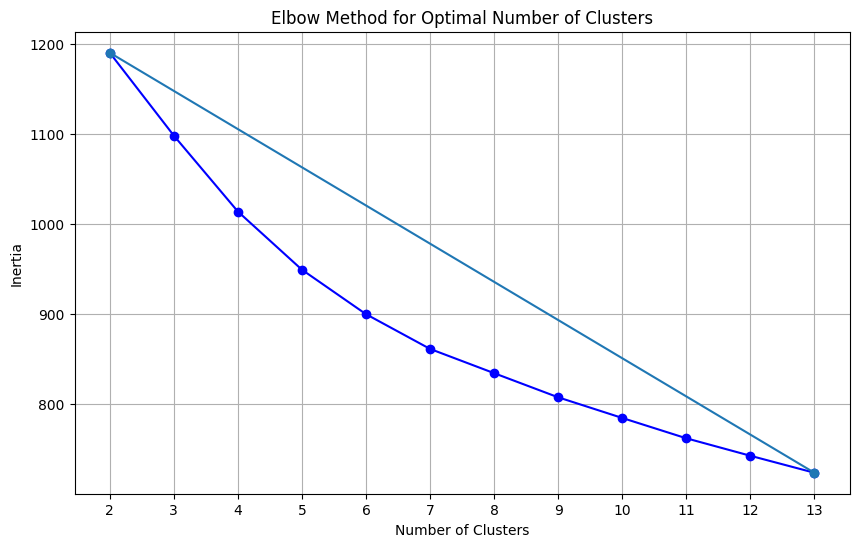

In [42]:
import matplotlib.pyplot as plt

xpoints = [13,2]
ypoints = [results[-1],results[0]]


plt.figure(figsize=(10, 6))
plt.plot(range(2, 14), results, marker='o', linestyle='-', color='b')
plt.plot(xpoints, ypoints, marker='o')

plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(2, 14))
plt.grid(True)
plt.show()

